The algorithm used in this toturial is from [QuantumFlow](https://www.nature.com/articles/s41467-020-20729-5) (Box-2 on Page 10). 

In [1]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import shutil
import os
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import functools
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.extensions import XGate, UnitaryGate
from qiskit import Aer, execute
from qiskit import IBMQ
import qiskit as q
import math

%load_ext autoreload
%autoreload 2
# %matplotlib inline

from utils import *
from U_layer import *
from P_layer import *

# account = q.IBMQ.load_account()

print = functools.partial(print, flush=True)

In [2]:

interest_num = [3,6]
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1
inference_batch_size = 1

# Data Processing

In [3]:
# Using torch to load MNIST data

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root='./data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)


Batch Id: 0, Target: tensor([1])


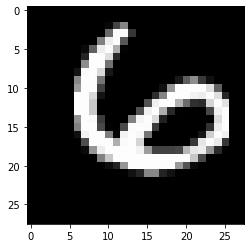

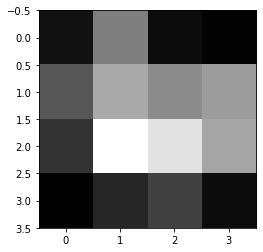

Classical Data: tensor([0.0314, 0.2314, 0.0235, 0.0039, 0.1569, 0.3098, 0.2549, 0.2863, 0.0941,
        0.4667, 0.4118, 0.3020, 0.0000, 0.0706, 0.1216, 0.0235])
Quantum Data: tensor([0.0344, 0.2539, 0.0258, 0.0043, 0.1722, 0.3400, 0.2797, 0.3142, 0.1033,
        0.5121, 0.4519, 0.3314, 0.0000, 0.0775, 0.1334, 0.0258],
       dtype=torch.float64)


In [4]:
# Use the first image from test loader as example
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data), img_size)
    break

Here, we appiled the tained weights obtained from QF-FB, which will be introduced in the later tutorial. 
But, at this moment, feel free to change the weights to see the circuit depth comparison.

For eaxmple, the following weights will lead the depth comparison to be 93:33.
<pre><code>weight_1_1 = torch.tensor([1.,  -1.,  -1.,  1.,  -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., 1., 1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])</code></pre> 

In [5]:
# Parameters of the trained model
# The training procedure will be found in another repo
# https://github.com/weiwenjiang/QuantumFlow

# Model initialization
weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

# P-LYR Circuit
Tutorial 3

In [6]:
# From Listing 2: create the qubits to hold data
inp_1 = QuantumRegister(4, "in1_qbit")
inp_2 = QuantumRegister(4, "in2_qbit")
circ = QuantumCircuit(inp_1, inp_2)
data_matrix = quantum_matrix
circ.append(UnitaryGate(data_matrix, label="Input"), inp_1[0:4])
circ.append(UnitaryGate(data_matrix, label="Input"), inp_2[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2, "aux_qbit")
circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(2, "hidden_qbits")
circ.add_register(hidden_neurons)


# From Listing 3: to multiply inputs and weights on quantum circuit
if weight_1_1.sum() < 0:
    weight_1_1 = weight_1_1*-1
idx = 0
for idx in range(weight_1_1.flatten().size()[0]):
    if weight_1_1[idx] == -1:
        state = "{0:b}".format(idx).zfill(4)    # 4 bit binary representation of idx
        neg_weight_gate(circ, inp_1, aux, state)
        circ.barrier()

if weight_1_2.sum() < 0:
    weight_1_2 = weight_1_2*-1
idx = 0
for idx in range(weight_1_2.flatten().size()[0]):
    if weight_1_2[idx] == -1:
        state = "{0:b}".format(idx).zfill(4)
        neg_weight_gate(circ, inp_2, aux, state)
        circ.barrier()

# From Listing 4: applying the quadratic function on the weighted sum
circ.h(inp_1)
circ.x(inp_1)
ccccx(circ, inp_1[0], inp_1[1], inp_1[2],
      inp_1[3], hidden_neurons[0], aux[0], aux[1])

circ.h(inp_2)
circ.x(inp_2)
ccccx(circ, inp_2[0], inp_2[1], inp_2[2],
      inp_2[3], hidden_neurons[1], aux[0], aux[1])


print("Hidden layer created!")

Hidden layer created!


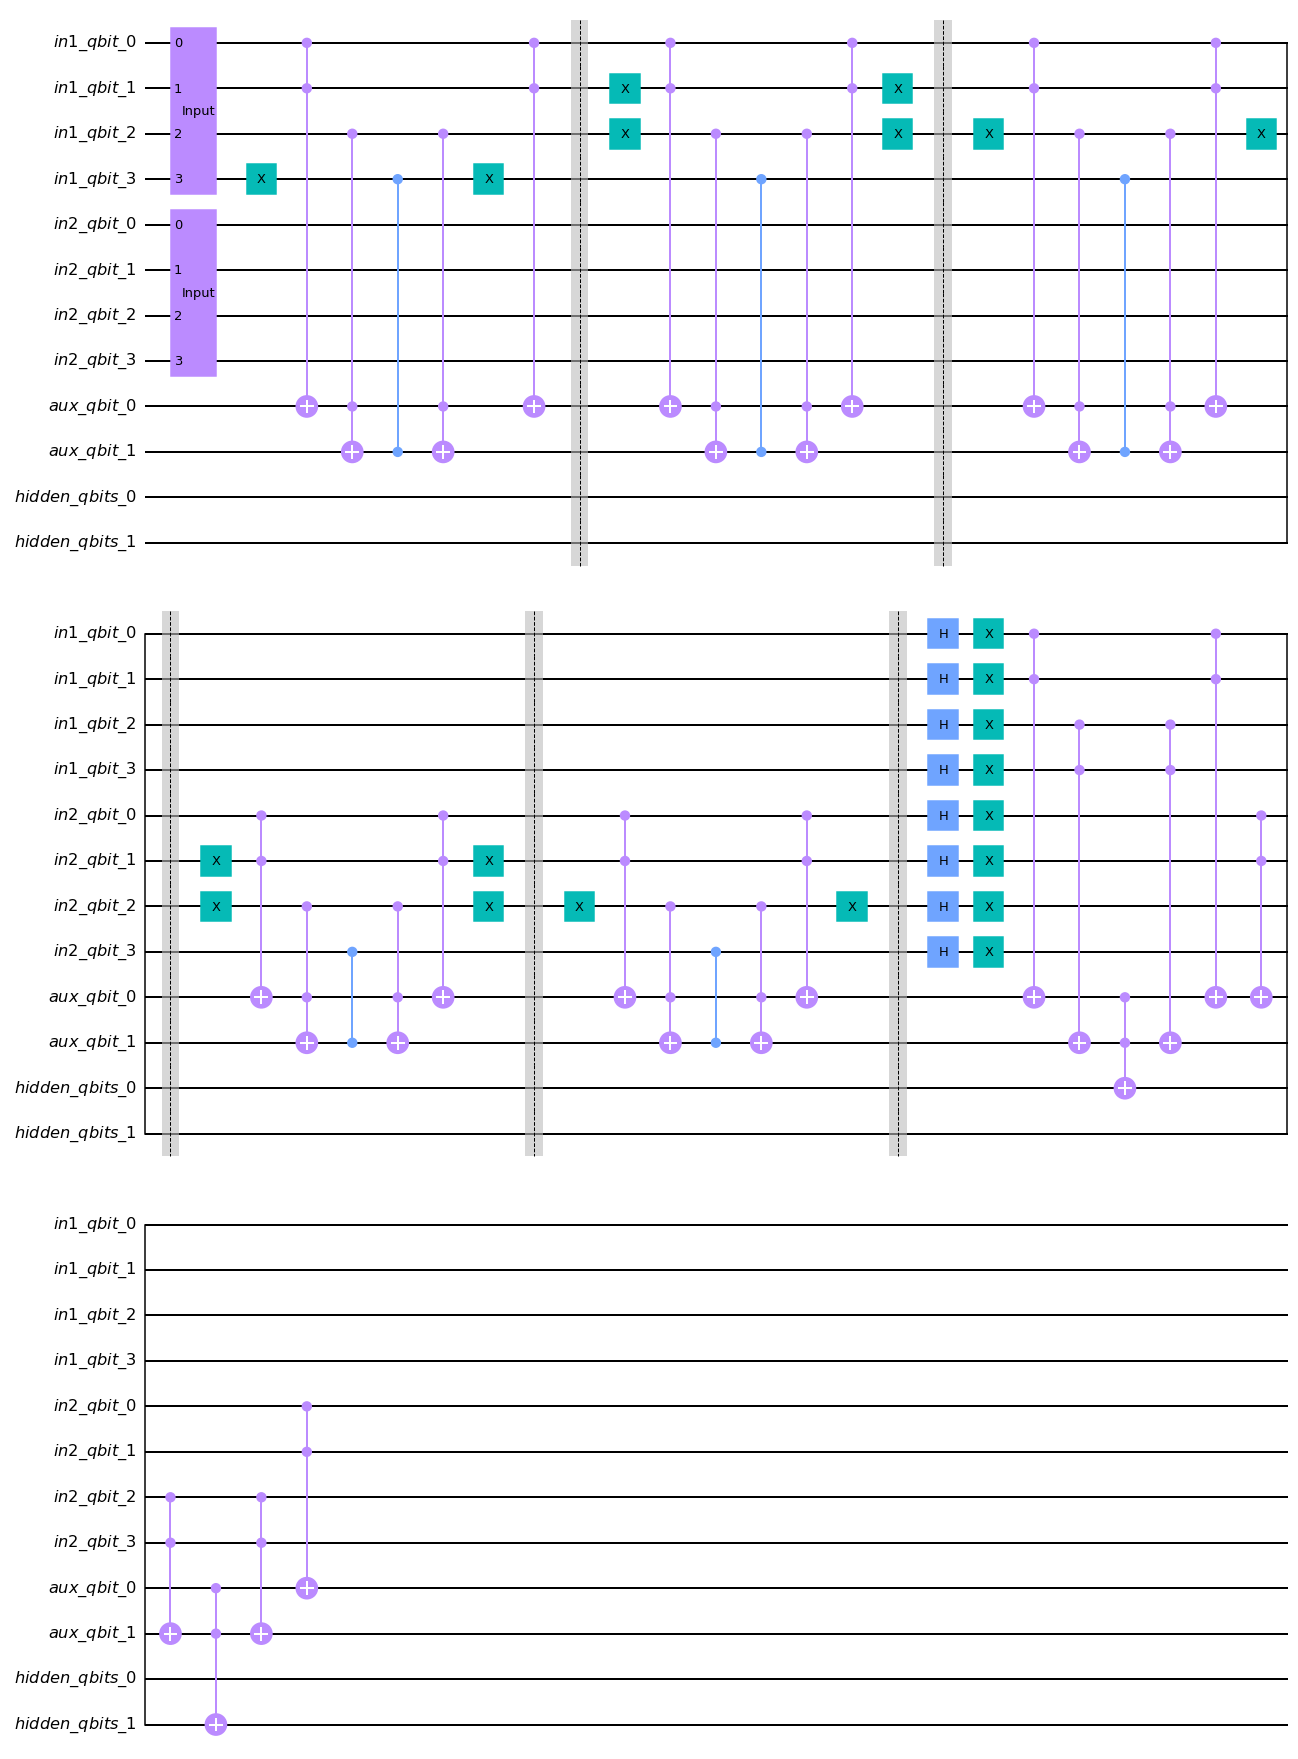

In [7]:
circ.draw("mpl")

In [8]:
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf

inter_q_1 = QuantumRegister(1,"inter_q_1_qbits")
norm_q_1 = QuantumRegister(1,"norm_q_1_qbits")
out_q_1 = QuantumRegister(1,"out_q_1_qbits")
circ.add_register(inter_q_1,norm_q_1,out_q_1)

circ.barrier()

if weight_2_1.sum()<0:
    weight_2_1 = weight_2_1*-1
idx = 0
for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_1)
circ.cz(hidden_neurons[0],inter_q_1)
circ.x(inter_q_1)
circ.cz(hidden_neurons[1],inter_q_1)
circ.x(inter_q_1)
circ.h(inter_q_1)
circ.x(inter_q_1)

circ.barrier()

norm_init_rad = float(norm_para_1.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_1)
if norm_flag_1:
    circ.cx(inter_q_1,out_q_1)
    circ.x(inter_q_1)
    circ.ccx(inter_q_1,norm_q_1,out_q_1)
else:
    circ.ccx(inter_q_1,norm_q_1,out_q_1)

for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()



inter_q_2 = QuantumRegister(1,"inter_q_2_qbits")
norm_q_2 = QuantumRegister(1,"norm_q_2_qbits")
out_q_2 = QuantumRegister(1,"out_q_2_qbits")
circ.add_register(inter_q_2,norm_q_2,out_q_2)

circ.barrier()

if weight_2_2.sum()<0:
    weight_2_2 = weight_2_2*-1
idx = 0
for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])
circ.h(inter_q_2)
circ.cz(hidden_neurons[0],inter_q_2)
circ.x(inter_q_2)
circ.cz(hidden_neurons[1],inter_q_2)
circ.x(inter_q_2)
circ.h(inter_q_2)
circ.x(inter_q_2)

circ.barrier()

norm_init_rad = float(norm_para_2.sqrt().arcsin()*2)
circ.ry(norm_init_rad,norm_q_2)
if norm_flag_2:
    circ.cx(inter_q_2,out_q_2)
    circ.x(inter_q_2)
    circ.ccx(inter_q_2,norm_q_2,out_q_2)
else:
    circ.ccx(inter_q_2,norm_q_2,out_q_2)

for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        circ.x(hidden_neurons[idx])

circ.barrier()

c_reg = ClassicalRegister(2,"reg")
circ.add_register(c_reg)
circ.measure(out_q_1,c_reg[0])
circ.measure(out_q_2,c_reg[1])

print("Output layer created!")

Output layer created!


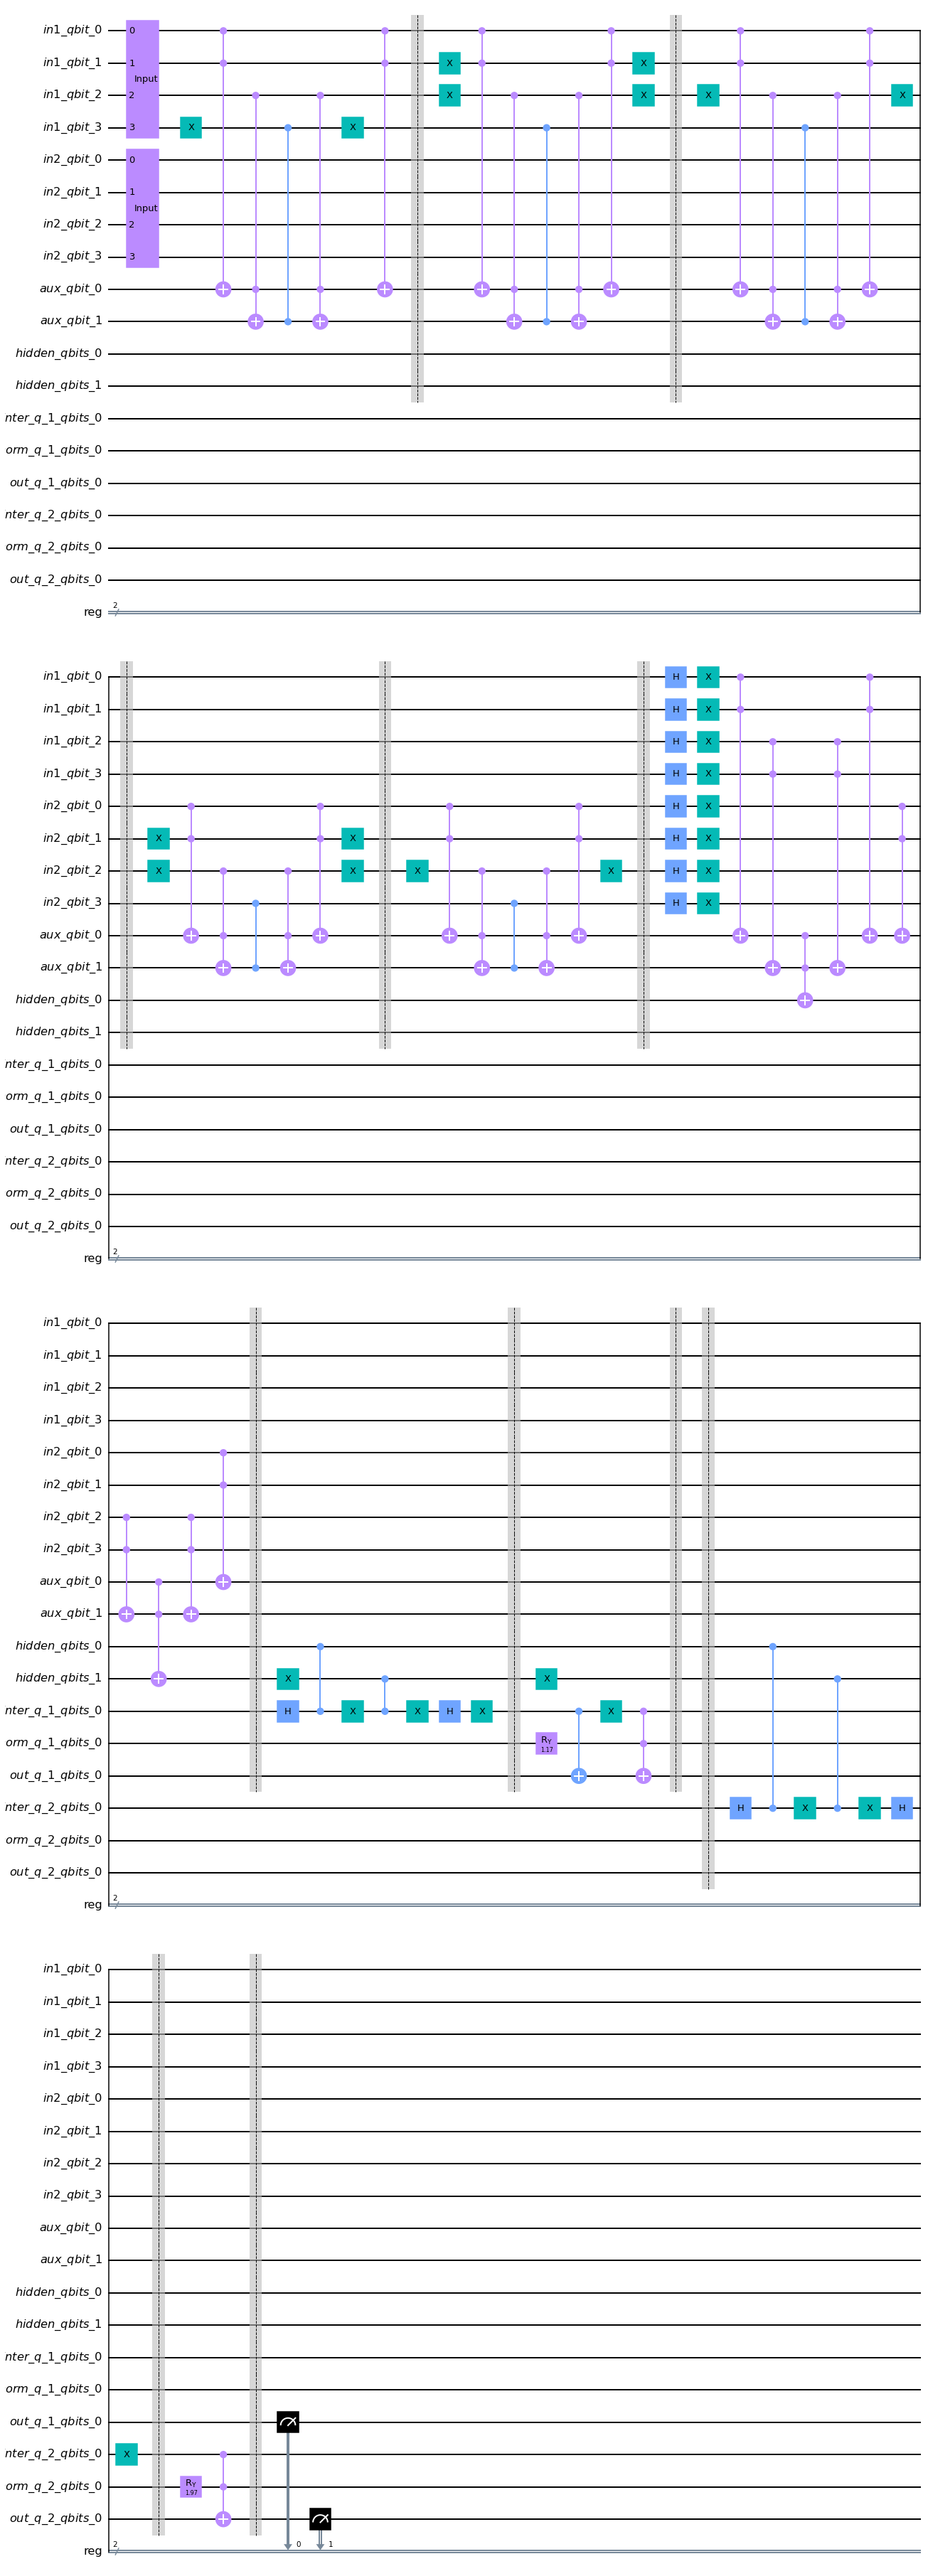

In [9]:
circ.draw("mpl")

# U-Layer Circuit

In the following, the optimized circuit (opt_circ) is created

In [10]:
# Optimized circuit

from U_layer import *

# From Listing 2: creat the qubits to hold data
inp_1 = QuantumRegister(4,"in1_qbit")
inp_2 = QuantumRegister(4,"in2_qbit")
opt_circ = QuantumCircuit(inp_1,inp_2)
data_matrix = quantum_matrix

n1_q_gates,n1_idx = qf_map_extract_from_weight(weight_1_1)
n2_q_gates,n2_idx = qf_map_extract_from_weight(weight_1_2)

opt_circ.append(UnitaryGate(data_matrix[n1_idx], label="Input"), inp_1[0:4])
opt_circ.append(UnitaryGate(data_matrix[n2_idx], label="Input"), inp_2[0:4])

# From Listing 3: create auxiliary qubits
aux = QuantumRegister(2,"aux_qbit")
opt_circ.add_register(aux)

# From Listing 4: create output qubits for the first layer (hidden neurons)
hidden_neurons = QuantumRegister(2,"hidden_qbits")
opt_circ.add_register(hidden_neurons)
qbits = inp_1
for gate in n1_q_gates:
    z_count = gate.count("1")
    # z_pos = get_index_list(gate,"1")
    z_pos = get_index_list(gate[::-1],"1")
    # print(z_pos)
    if z_count==1:
        opt_circ.z(qbits[z_pos[0]])
    elif z_count==2:
        opt_circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        ccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux[0])
    elif z_count==4:
        cccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux[0],aux[1])

qbits = inp_2
for gate in n2_q_gates:
    z_count = gate.count("1")
    # z_pos = get_index_list(gate,"1")
    z_pos = get_index_list(gate[::-1],"1")
    # print(z_pos)
    if z_count==1:
        opt_circ.z(qbits[z_pos[0]])
    elif z_count==2:
        opt_circ.cz(qbits[z_pos[0]],qbits[z_pos[1]])
    elif z_count==3:
        ccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],aux[0])
    elif z_count==4:
        cccz(opt_circ,qbits[z_pos[0]],qbits[z_pos[1]],qbits[z_pos[2]],qbits[z_pos[3]],aux[0],aux[1])

opt_circ.barrier()

# From Listing 4: applying the quadratic function on the weighted sum
opt_circ.h(inp_1)
opt_circ.x(inp_1)
ccccx(opt_circ,inp_1[0],inp_1[1],inp_1[2],inp_1[3],hidden_neurons[0],aux[0],aux[1])

opt_circ.h(inp_2)
opt_circ.x(inp_2)
ccccx(opt_circ,inp_2[0],inp_2[1],inp_2[2],inp_2[3],hidden_neurons[1],aux[0],aux[1])


print("Hidden layer created!")

Hidden layer created!


In [11]:
# Quantum circuit implementation of the output layer
# fundamentals, please see our Nature Communication
# paper (P-LYR) https://arxiv.org/pdf/2006.14815.pdf

inter_q_1 = QuantumRegister(1,"inter_q_1_qbits")
norm_q_1 = QuantumRegister(1,"norm_q_1_qbits")
out_q_1 = QuantumRegister(1,"out_q_1_qbits")
opt_circ.add_register(inter_q_1,norm_q_1,out_q_1)

opt_circ.barrier()

if weight_2_1.sum()<0:
    weight_2_1 = weight_2_1*-1
idx = 0
for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:\

        
        opt_circ.x(hidden_neurons[idx])
opt_circ.h(inter_q_1)
opt_circ.cz(hidden_neurons[0],inter_q_1)
opt_circ.x(inter_q_1)
opt_circ.cz(hidden_neurons[1],inter_q_1)
opt_circ.x(inter_q_1)
opt_circ.h(inter_q_1)
opt_circ.x(inter_q_1)

opt_circ.barrier()

norm_init_rad = float(norm_para_1.sqrt().arcsin()*2)
opt_circ.ry(norm_init_rad,norm_q_1)
if norm_flag_1:
    opt_circ.cx(inter_q_1,out_q_1)
    opt_circ.x(inter_q_1)
    opt_circ.ccx(inter_q_1,norm_q_1,out_q_1)
else:
    opt_circ.ccx(inter_q_1,norm_q_1,out_q_1)

for idx in range(weight_2_1.flatten().size()[0]):
    if weight_2_1[idx]==-1:
        opt_circ.x(hidden_neurons[idx])

opt_circ.barrier()




inter_q_2 = QuantumRegister(1,"inter_q_2_qbits")
norm_q_2 = QuantumRegister(1,"norm_q_2_qbits")
out_q_2 = QuantumRegister(1,"out_q_2_qbits")
opt_circ.add_register(inter_q_2,norm_q_2,out_q_2)

opt_circ.barrier()

if weight_2_2.sum()<0:
    weight_2_2 = weight_2_2*-1
idx = 0
for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        opt_circ.x(hidden_neurons[idx])
opt_circ.h(inter_q_2)
opt_circ.cz(hidden_neurons[0],inter_q_2)
opt_circ.x(inter_q_2)
opt_circ.cz(hidden_neurons[1],inter_q_2)
opt_circ.x(inter_q_2)
opt_circ.h(inter_q_2)
opt_circ.x(inter_q_2)

opt_circ.barrier()

norm_init_rad = float(norm_para_2.sqrt().arcsin()*2)
opt_circ.ry(norm_init_rad,norm_q_2)
if norm_flag_2:
    opt_circ.cx(inter_q_2,out_q_2)
    opt_circ.x(inter_q_2)
    opt_circ.ccx(inter_q_2,norm_q_2,out_q_2)
else:
    opt_circ.ccx(inter_q_2,norm_q_2,out_q_2)

for idx in range(weight_2_2.flatten().size()[0]):
    if weight_2_2[idx]==-1:
        opt_circ.x(hidden_neurons[idx])

opt_circ.barrier()

c_reg = ClassicalRegister(2,"reg")
opt_circ.add_register(c_reg)
opt_circ.measure(out_q_1,c_reg[0])
opt_circ.measure(out_q_2,c_reg[1])

print("Output layer created!")

Output layer created!


# Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [12]:
# Quantum simulation

# Non-Optimized one
qc_shots = 8192
counts = fire_ibmq(circ, qc_shots, Simulation=True)
(mycount, bits) = analyze(counts)
class_prob = []
for b in range(bits):
    class_prob.append(float(mycount[b])/qc_shots)

print("="*10, "Non-Optimized Circuit", "="*10)
print("Non-Optimized Circuit Depth:", circ.depth())
print("Result of non-optimized QC:", class_prob)
print("Prediction class: {}".format(class_prob.index(max(class_prob))))
print("Target class: {}".format(target[0]))
if class_prob.index(max(class_prob)) == target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

print("="*30)

# Optimized one
qc_shots = 8192
opt_counts = fire_ibmq(opt_circ, qc_shots, Simulation=True)
(opt_mycount, bits) = analyze(opt_counts)
opt_class_prob = []
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("="*10, "Optimized Circuit", "="*10)
print("Optimized Circuit Depth:", opt_circ.depth())
print("Result of optimized QC:", opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob)) == target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")

print("="*30)


Job Status: job has successfully run
========== Non-Optimized Circuit ==========
Non-Optimized Circuit Depth: 58
Result of non-optimized QC: [0.41552734375, 0.5888671875]
Prediction class: 1
Target class: 1
Correct prediction
Job Status: job has successfully run
========== Optimized Circuit ==========
Optimized Circuit Depth: 38
Result of optimized QC: [0.4151611328125, 0.584716796875]
Prediction class: 1
Target class: 1
Correct prediction


In [13]:
from P_layer import *
from utils import *

weight_1_1 = torch.tensor([1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,    1.,  1.])
weight_1_2 = torch.tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,-1., -1.])

weight_2_1 = torch.tensor([1.,  -1.])
norm_flag_1 = True
norm_para_1 = torch.tensor(0.3060)

weight_2_2 = torch.tensor([-1.,  -1.])
norm_flag_2 = False
norm_para_2 = torch.tensor(0.6940)

weights = [weight_1_1, weight_1_2, weight_2_1, weight_2_2]
flags = [norm_flag_1, norm_flag_2]
params = [norm_para_1, norm_para_2]

p_circ = p_circ_gen(quantum_matrix, weights, flags, params)

In [15]:
from U_layer import *

u_circ = u_circ_gen(quantum_matrix, weights, flags, params)

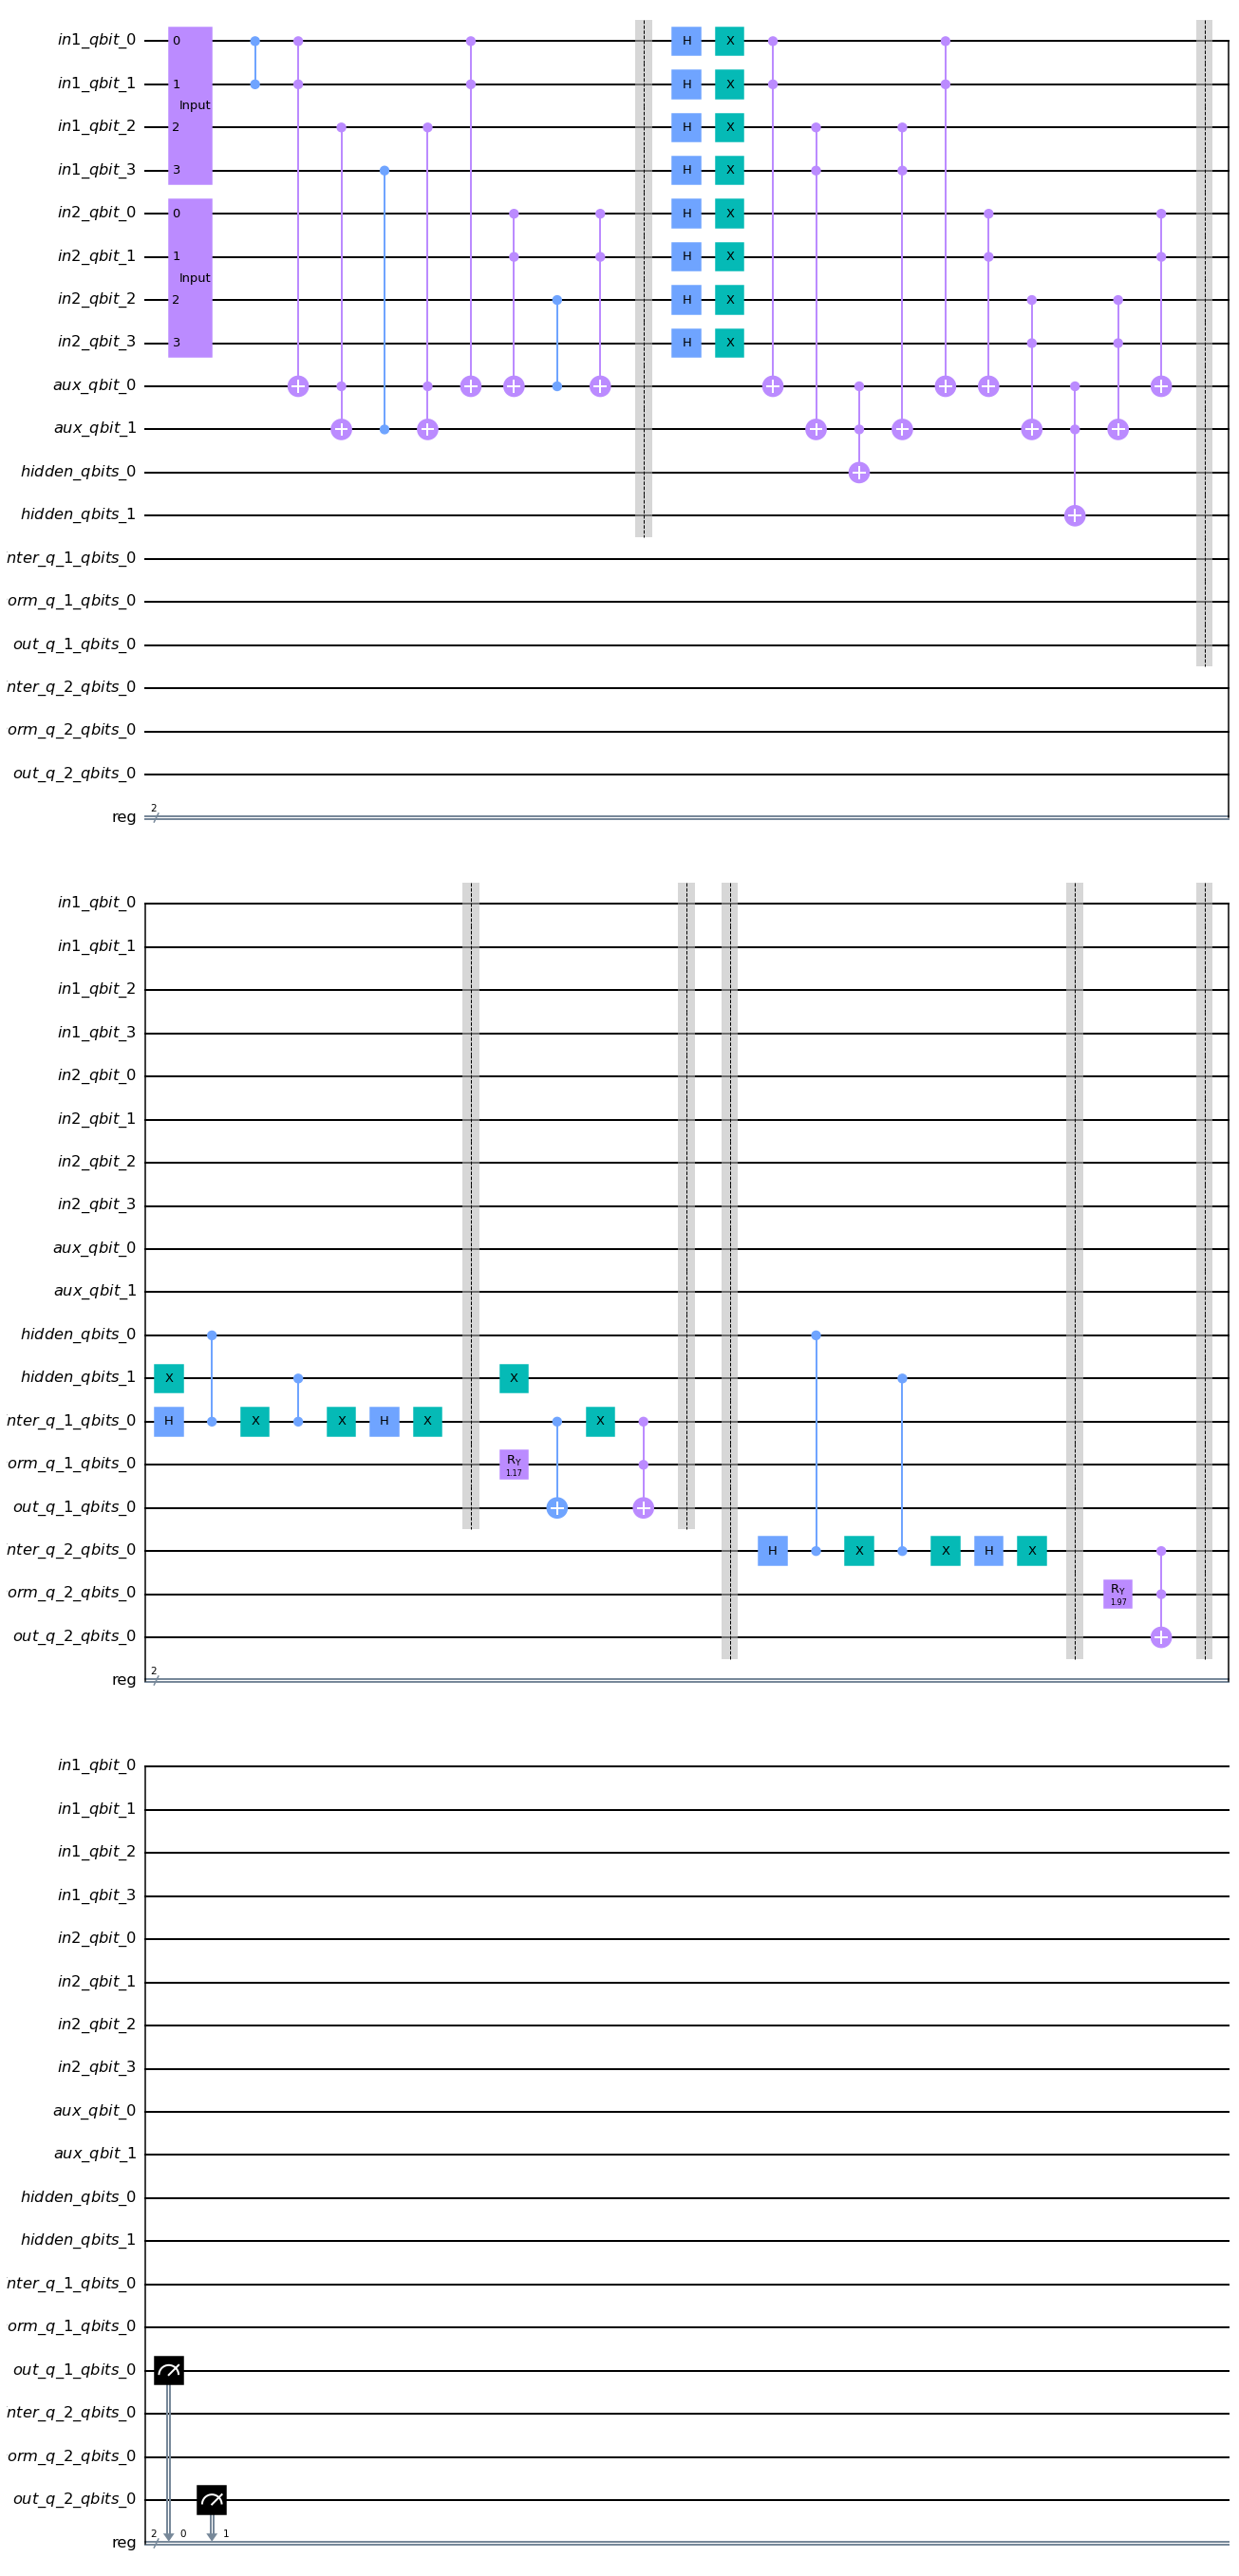

In [17]:
u_circ.draw()